## Lectures
 - [Value functions approximation - RL by David Silver](https://www.youtube.com/watch?v=UoPei5o4fps&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=6)
    - Differentiable function approximators
    - Incremental methods
    - Batch methods (DQN)

### Reading:
 - [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/pdf/1312.5602.pdf)
 - [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
  - Preprocessing.
  - Deep Q-learning.
  - Hyperparameters

### Coding
This week we will apply Deep Q-Networks (DQN) to Pong.

### Explore the environment:
- https://gym.openai.com/envs/Pong-v0/

### install env: 
 - pip install atari-py

In [1]:
import gym
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize
import random 
import torch
import os
import time
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
class Preprocessor():
    def __init__(self, game, h, w, device, n_frame=4):
        self.game = game
        self.h, self.w = h, w
        self.set_box(game)
        self.n_frame = n_frame
        self.history = []
        self.device = device
        self.delta_value = 256
    def set_box(self, game):
        if self.game == 'pong':
            self.box = [35, 193, 0, self.w]
        
    def phi(self, rbg, to_tensor=True):
        stack = None
        frame = self.rgb2gray(rbg)
        self.history.append(frame)
        if len(self.history) == self.n_frame:
            stack = np.stack(self.history)
            if to_tensor:
                stack = self.to_tensor([stack])
        self.history = self.history[-(self.n_frame-1):]
        return stack
    
    def to_tensor(self, frames):
        frame = torch.from_numpy(np.stack(frames)).float().to(self.device)
        return frame
    
    def rgb2gray(self, rgb):
        rgb = rgb[self.box[0]:self.box[1], self.box[2]: self.box[3]]
        rgb = np.array(Image.fromarray(rgb).resize((84,84)))
        gray = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
        gray = gray / self.delta_value
        return gray

In [4]:
preprocessor = Preprocessor('pong', 210, 160, device)

In [5]:
env = gym.make("Pong-v0")
observation = env.reset()

In [6]:
observation.shape

(210, 160, 3)

In [7]:
for action_id, name in enumerate(env.unwrapped.get_action_meanings()):
    print(action_id, name)

0 NOOP
1 FIRE
2 RIGHT
3 LEFT
4 RIGHTFIRE
5 LEFTFIRE


In [8]:
NOOP, RIGHT, LEFT= 0, 2, 3

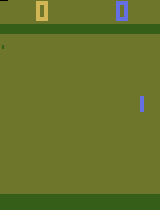

In [10]:
Image.fromarray(observation)

In [9]:
ob = env.reset()

(0.0, False, {'ale.lives': 0}, (84, 84))

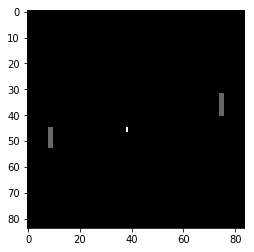

In [36]:
observation, reward, done, info = env.step(0)
frame = preprocessor.rgb2gray(observation)
plt.imshow(frame, cmap = "gray")
reward, done, info, frame.shape

In [37]:
frame.max()

0.9217828124999999

In [38]:
ob = env.reset()

In [ ]:
# i = 92
# t = D.D_win[i][0][0][0].cpu().numpy()
# plt.imshow(t, cmap = "gray")
# time.sleep(0.2)

In [ ]:
# frame.shape

(0.0, False, {'ale.lives': 0}, (84, 84), torch.Size([1, 4, 84, 84]))

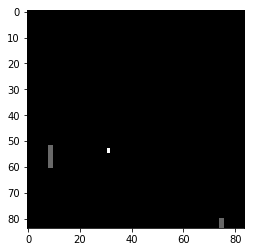

In [84]:
observation, reward, done, info = env.step(3)
frame = preprocessor.rgb2gray(observation)
frames = preprocessor.phi(observation)
plt.imshow(frame, cmap = "gray")
reward, done, info, frame.shape, frames.shape

In [91]:
# Test preprocess:

In [80]:
def plot_images(images,):
    assert len(images) == 4
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
def show_image_from_frames(frames):
    images = np.array(frames.cpu())[0]
    plot_images(images)

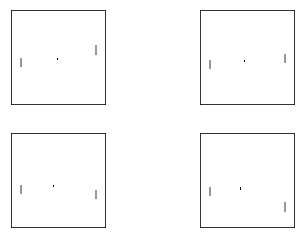

In [81]:
show_image_from_frames(frames)

### Build model:

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0],32,8,stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(), 
            nn.Linear(512, n_actions))
    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [152]:
# Test model:

In [220]:
def run_optimizer(Q_net, frames, lr=0.1, n_iter=1, is_train = [True, False, False]):
    optimizer = torch.optim.RMSprop(Q_net.parameters(), lr=lr)
    for i in range(n_iter):
        loss = None
        y_hat = Q_net(frames)
        print(f"y_hat {y_hat}.")
        idx = torch.LongTensor([[0]]).to(device)
        y_0 = torch.gather(y_hat, 1, idx)
        print(f"y_0 {y_0}.")
        idx = torch.LongTensor([[1]]).to(device)
        y_1 = torch.gather(y_hat, 1, idx)
        print(f"y_1 {y_1}")
        idx = torch.LongTensor([[2]]).to(device)
        y_2 = torch.gather(y_hat, 1, idx)
        print(f"y_2 {y_2}")
        optimizer.zero_grad()
        
        if is_train[0]:
            y =  torch.from_numpy(np.array([-1])).float().to(device)
            loss1 = nn.MSELoss()(y_0, y)
            if loss:
                loss += loss1
            else:
                loss = loss1
        
        if is_train[1]:
            y =  torch.from_numpy(np.array([1])).float().to(device)
            loss2 = nn.MSELoss()(y_1, y)
            if loss:
                loss += loss2
            else:
                loss = loss2
                
        if is_train[2]:
            y =  torch.from_numpy(np.array([1])).float().to(device)
            loss3 = nn.MSELoss()(y_2, y)
            if loss:
                loss += loss3
            else:
                loss = loss3
                
        loss.backward()
        optimizer.step()
        
        print(f"new y_hat {Q_net(frames)}")

In [224]:
Q_net = DQN([4], 3) 
run_optimizer(Q_net, frames, lr=1, n_iter=2, is_train=[True, True, True])

y_hat tensor([[ 0.0228,  0.0792, -0.0545]], grad_fn=<AddmmBackward>).
y_0 tensor([[0.0228]], grad_fn=<GatherBackward>).
y_1 tensor([[0.0792]], grad_fn=<GatherBackward>)
y_2 tensor([[-0.0545]], grad_fn=<GatherBackward>)
new y_hat tensor([[-1.1337e+08,  1.1334e+08,  1.1332e+08]], grad_fn=<AddmmBackward>)
y_hat tensor([[-1.1337e+08,  1.1334e+08,  1.1332e+08]], grad_fn=<AddmmBackward>).
y_0 tensor([[-1.1337e+08]], grad_fn=<GatherBackward>).
y_1 tensor([[1.1334e+08]], grad_fn=<GatherBackward>)
y_2 tensor([[1.1332e+08]], grad_fn=<GatherBackward>)
new y_hat tensor([[ 15538628., -15527594., -15537142.]], grad_fn=<AddmmBackward>)


In [225]:
Q_net = DQN([4], 3) 
run_optimizer(Q_net, frames, lr=0.01, n_iter=2, is_train=[True, True, True])

y_hat tensor([[-0.0037, -0.0609, -0.0716]], grad_fn=<AddmmBackward>).
y_0 tensor([[-0.0037]], grad_fn=<GatherBackward>).
y_1 tensor([[-0.0609]], grad_fn=<GatherBackward>)
y_2 tensor([[-0.0716]], grad_fn=<GatherBackward>)
new y_hat tensor([[-404.1568,  396.7926,  400.1288]], grad_fn=<AddmmBackward>)
y_hat tensor([[-404.1568,  396.7926,  400.1288]], grad_fn=<AddmmBackward>).
y_0 tensor([[-404.1568]], grad_fn=<GatherBackward>).
y_1 tensor([[396.7926]], grad_fn=<GatherBackward>)
y_2 tensor([[400.1288]], grad_fn=<GatherBackward>)
new y_hat tensor([[ 102.8662, -110.1030, -109.5303]], grad_fn=<AddmmBackward>)


In [226]:
Q_net = DQN([4], 3) 
run_optimizer(Q_net, frames, lr=0.0001, n_iter=2, is_train=[True, True, True])

y_hat tensor([[-0.0398, -0.1603,  0.2148]], grad_fn=<AddmmBackward>).
y_0 tensor([[-0.0398]], grad_fn=<GatherBackward>).
y_1 tensor([[-0.1603]], grad_fn=<GatherBackward>)
y_2 tensor([[0.2148]], grad_fn=<GatherBackward>)
new y_hat tensor([[-1.6907,  1.6267,  1.4938]], grad_fn=<AddmmBackward>)
y_hat tensor([[-1.6907,  1.6267,  1.4938]], grad_fn=<AddmmBackward>).
y_0 tensor([[-1.6907]], grad_fn=<GatherBackward>).
y_1 tensor([[1.6267]], grad_fn=<GatherBackward>)
y_2 tensor([[1.4938]], grad_fn=<GatherBackward>)
new y_hat tensor([[-0.3705,  0.7817,  0.5067]], grad_fn=<AddmmBackward>)


In [234]:
Q_net = DQN([4], 3) 
run_optimizer(Q_net, frames, lr=0.00003, n_iter=4, is_train=[True, True, True])

y_hat tensor([[ 0.1684,  0.0417, -0.0422]], grad_fn=<AddmmBackward>).
y_0 tensor([[0.1684]], grad_fn=<GatherBackward>).
y_1 tensor([[0.0417]], grad_fn=<GatherBackward>)
y_2 tensor([[-0.0422]], grad_fn=<GatherBackward>)
new y_hat tensor([[-0.3375,  0.5080,  0.5443]], grad_fn=<AddmmBackward>)
y_hat tensor([[-0.3375,  0.5080,  0.5443]], grad_fn=<AddmmBackward>).
y_0 tensor([[-0.3375]], grad_fn=<GatherBackward>).
y_1 tensor([[0.5080]], grad_fn=<GatherBackward>)
y_2 tensor([[0.5443]], grad_fn=<GatherBackward>)
new y_hat tensor([[-0.6437,  0.6848,  0.7033]], grad_fn=<AddmmBackward>)
y_hat tensor([[-0.6437,  0.6848,  0.7033]], grad_fn=<AddmmBackward>).
y_0 tensor([[-0.6437]], grad_fn=<GatherBackward>).
y_1 tensor([[0.6848]], grad_fn=<GatherBackward>)
y_2 tensor([[0.7033]], grad_fn=<GatherBackward>)
new y_hat tensor([[-0.7459,  0.8427,  0.8287]], grad_fn=<AddmmBackward>)
y_hat tensor([[-0.7459,  0.8427,  0.8287]], grad_fn=<AddmmBackward>).
y_0 tensor([[-0.7459]], grad_fn=<GatherBackward>).
y_1

In [230]:
# good learning rate is about 0.00003

### Data loader:

In [87]:
class DataLoader():
    def __init__(self, batch_size, win_buffer_start_size=1000, loss_buffer_start_size=3001, buffer_capacity=40000):
        self.batch_size = batch_size
        self.D_win = []
        self.D_lose = []
        self.buffer_capacity = buffer_capacity
        self.loss_buffer_start_size = loss_buffer_start_size
        self.win_buffer_start_size = win_buffer_start_size
        self.game = []
        
    def reset_game(self,):
        self.game = []
        
    def add_sample(self, sample):
        if sample:
            self.game.append(sample)
            reward = sample[2]
            
            if reward == -1:
                for step in self.game[30:]:
                    self.D_lose.append(step)
                self.reset_game()
                if len(self.D_lose) > self.buffer_capacity:
                    self.D_lose = self.D_lose[-(self.buffer_capacity // 2):]
            if reward == 1:
                for step in self.game[30:]:
                    self.D_win.append(step)
                self.reset_game()
                if len(self.D_win) > self.buffer_capacity:
                    self.D_win = self.D_win[-(self.buffer_capacity // 2):]
            
    def get_sample(self):
        batch = None
        is_mixed = True
        if len(self.D_win) > self.win_buffer_start_size:
            batch_win = random.sample(self.D_win, self.batch_size // 2)
            batch_lose = random.sample(self.D_lose, self.batch_size // 2)
            batch = batch_win + batch_lose
        elif len(self.D_lose) > self.loss_buffer_start_size:
            is_mixed = False
            batch = random.sample(self.D_lose, self.batch_size)
        return batch, is_mixed
    
    def __len__(self):
        return len(self.D_win), len(self.D_lose)
    
    def __getitem__(self, idx, is_win=False):
        if is_win:
            D = self.D_win
        else:
            D = self.D_lose
        if idx < 0 or idx > len(D) - 1:
            return None
        return D[idx]

### Algorithm 1: deep Q-learning with experience replay.

In [88]:
class Policy():
    def __init__(self, Q, n_action, device, win_gamma=1, loss_gamma=0.9, epsilon=1, alpha=0.8, learning_rate=0.003):
        self.win_gamma = win_gamma
        self.loss_gamma = loss_gamma
        self.episode = 1
        self.alpha = alpha
        self.epsilon = epsilon
        self.EPS_DECAY_RATE = 0.9999
        self.n_action = n_action
        self.learning_rate = learning_rate
        self.action_mapper = [NOOP, RIGHT, LEFT]
        self.final_exploration = 0.1
        self.device = device
        # Step 1: Initilize Q(State, Action)
        self.net = Q.to(device)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=learning_rate)
        self.model_path = './models/DQN/checkpoint.pth.tar'
        
    def update_epsilon(self,):
        self.epsilon *= self.EPS_DECAY_RATE
        
    def save_model(self,):
        torch.save({'state_dict': self.net.state_dict()}, self.model_path)
        
    def load_model(self,):
        if os.path.isfile(self.model_path):
            checkpoint = torch.load(self.model_path)
            self.net.load_state_dict(checkpoint['state_dict'])
            self.net = self.net.to(self.device)
        
    def to_tensor(self, frames):
        frame = torch.from_numpy(np.stack(frames)).float().to(self.device)
        return frame
    
    def update_state_dict(self, Q):
        self.net.load_state_dict(Q.net.state_dict())
        
    def get_y_hat(self, batch):
        batch_state = [sample[0] for sample in batch]
        y_Q = self.net(torch.cat(batch_state))

        batch_a = [[sample[1]] for sample in batch]
        idx = torch.LongTensor(batch_a).to(device)
        y_Q = torch.gather(y_Q, 1, idx)
#         state_action_values = self.moving_nn(states_t).gather(1, actions_t[:,None]).squeeze(-1)
        return y_Q
    
    def update_Q(self, y, batch):
        y_hat_Q = self.get_y_hat(batch)
        loss = self.loss_fn(y_hat_Q, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_target(self, batch, is_mixed=False, verbose=False):
        r_t = torch.from_numpy(np.array([sample[2] for sample in batch])).float().to(self.device)
        if verbose:
            print('r_t', r_t)
        s_t_plus_1 = [sample[3] for sample in batch]
        
        q_t_plus_1 = self.net(torch.cat(s_t_plus_1))
        if verbose:
            print('q_t_plus_1 for all action: ', q_t_plus_1)
        q_t_plus_1 = q_t_plus_1.max(dim=1)[0]
        if verbose:
            print('q_t_plus_1', q_t_plus_1)
        if is_mixed:
            q_t_plus_1[0:len(q_t_plus_1)//2] = q_t_plus_1[0:len(q_t_plus_1)//2] * self.win_gamma
            q_t_plus_1[len(q_t_plus_1)//2:] = q_t_plus_1[len(q_t_plus_1)//2:] * self.loss_gamma
        else:
            q_t_plus_1 = q_t_plus_1 * self.loss_gamma
        if verbose:
            print('q_t_plus_1 with gamma', q_t_plus_1)
        idx = (r_t != -1) & (r_t != 1)
        r_t[idx] += q_t_plus_1[idx]
        # do net train target value
        return r_t
    
    def get_next_action(self, state, is_e_greedy=False):
        if is_e_greedy and np.random.random() < max(self.epsilon, self.final_exploration):
            next_action = np.random.randint(self.n_action)
            return next_action, self.action_mapper[next_action]
        
        output = self.net(state)
        _, next_action = torch.max(output, dim=1)
        next_action = next_action.item()
        return next_action, self.action_mapper[next_action]
    

In [ ]:
# len(D.D_lose) > D.buffer_capacity

In [ ]:
# print(len(D.D_win))
# batch, _ = D.get_sample(is_win=True)
# target = Q_hat.get_target(batch, verbose=True)
# y_hat = Q.get_y_hat(batch)
# target, y_hat.view(-1)

In [ ]:
# batch, _ = D.get_sample(is_win=False)
# target = Q_hat.get_target(batch, verbose=True)
# y_hat = Q.get_y_hat(batch)
# target, y_hat.view(-1)

In [18]:
preprocessor = Preprocessor('pong', 210, 160, device)

In [19]:
D = DataLoader(32)

In [946]:
epsilon=1
Q = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
Q.load_model()
Q_hat = Policy(DQN([4,84,84], 3), 3, device, epsilon=epsilon)
Q_hat.update_state_dict(Q)

In [656]:
def play(env, Q, preprocessor):
    observation = env.reset()

    for i in range(5):
        observation, reward, done, info = env.step(0)
        phi_t = preprocessor.phi(observation)
    for t in range(10000):
        time.sleep(0.1)
        env.render()
        index_a_t, a_t = Q.get_next_action(phi_t, is_e_greedy=False)
        time.sleep(0.1)
        x_t_plus_1, r_t, done, info = env.step(a_t)
        phi_t = preprocessor.phi(x_t_plus_1)
        if r_t == -1:
            break

In [22]:
n_win = 0

In [ ]:
C = 3
MAX_N_GAMES = 1
scores = [0,0]
counter = 0
for episode in range(MAX_N_GAMES):
    observation = env.reset()
    
    for i in range(5):
        observation, reward, done, info = env.step(0)
        phi_t = preprocessor.phi(observation)
    
    for t in range(10000):
        # get next action:
        index_a_t, a_t = Q.get_next_action(phi_t, is_e_greedy=True)
        if n_win > 100:
            Q.update_epsilon()
        # get next state and reward:
        x_t_plus_1, r_t, done, info = env.step(a_t)
        if r_t == -1:
            scores[0]+=1
        if r_t == 1:
            scores[1]+=1
            n_win+=1
        phi_t_plus_1 = preprocessor.phi(x_t_plus_1)
        # enrich dataset:
        D.add_sample((phi_t, index_a_t, r_t, phi_t_plus_1))
        
        # update value:np.random.random()
        batch, is_mixed = D.get_sample()
        if batch:
            y = Q_hat.get_target(batch, is_mixed=is_mixed)
            y = y.detach()
            Q.update_Q(y, batch)
        # reset state for new loop
        phi_t = phi_t_plus_1
        counter += 1
        if (episode % C) == 0:
            Q_hat.update_state_dict(Q)
        if done:
            print(f"episode: {episode}, score: agent vs AI: {scores[0]} - {scores[1]}")
            scores = [0,0]
            break
    if (episode + 1) % 500 == 0:
        print("Save model!")
        Q.save_model()
#         play(env, Q, preprocessor)
Q_hat.update_state_dict(Q)
Q.save_model()

In [ ]:
batch, is_mixed = D.get_sample()
print(is_mixed)
target = Q_hat.get_target(batch, is_mixed=is_mixed,verbose=True)
y_hat = Q.get_y_hat(batch)
target, y_hat.view(-1)